# **Group Assignment** - Bike Sharing

- `instant`: record index
- `dteday` : date
- `season` : season (1:springer, 2:summer, 3:fall, 4:winter)
- `yr` : year (0: 2011, 1:2012)
- `mnth` : month ( 1 to 12)
- `hr` : hour (0 to 23)
- `holiday` : wether day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- `weekday` : day of the week
- `workingday` : if day is neither weekend nor holiday is 1, otherwise is 0.
+ `weathersit` : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- `temp` : Normalized temperature in Celsius. The values are divided to 41 (max)
- `atemp`: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- `hum`: Normalized humidity. The values are divided to 100 (max)
- `windspeed`: Normalized wind speed. The values are divided to 67 (max)
- `casual`: count of casual users
- `registered`: count of registered users
- `cnt`: count of total rental bikes including both casual and registered

## PART I: Exploratory Data Analysis

### Set Up

In [1]:
# import all necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.subplots as sp
import plotly.graph_objs as go
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFECV
from sklearn.tree import plot_tree


In [2]:
# read in and inspect data
df1=pd.read_csv("bike-sharing_hourly.csv")
df1.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

In [3]:
df = df1.copy()

In [4]:
# inspect data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


As seen above:
- All variables both categorical and numerical are numerically encoded.
- Date is an object so needs to be converted to a date time object
- There are no null values

In [5]:
# convert date column to datetime datatype
df["dteday"]=pd.to_datetime(df["dteday"])

In [6]:
# create a validation set doing the first 10% split on our data
# split needs to be done on the first row of a day
mask2 = df['dteday'] >= '2012-10-19'
# filter the dataframe using the boolean mask
test_df = df.loc[mask2]

# output our original dataframe without the first 10% split
mask1 = df['dteday'] < '2012-10-19'
#filter the dataframe using the boolean mask
df = df.loc[mask1]

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1736 entries, 15643 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     1736 non-null   int64         
 1   dteday      1736 non-null   datetime64[ns]
 2   season      1736 non-null   int64         
 3   yr          1736 non-null   int64         
 4   mnth        1736 non-null   int64         
 5   hr          1736 non-null   int64         
 6   holiday     1736 non-null   int64         
 7   weekday     1736 non-null   int64         
 8   workingday  1736 non-null   int64         
 9   weathersit  1736 non-null   int64         
 10  temp        1736 non-null   float64       
 11  atemp       1736 non-null   float64       
 12  hum         1736 non-null   float64       
 13  windspeed   1736 non-null   float64       
 14  casual      1736 non-null   int64         
 15  registered  1736 non-null   int64         
 16  cnt         1736 no

### Visualize Data

<AxesSubplot:>

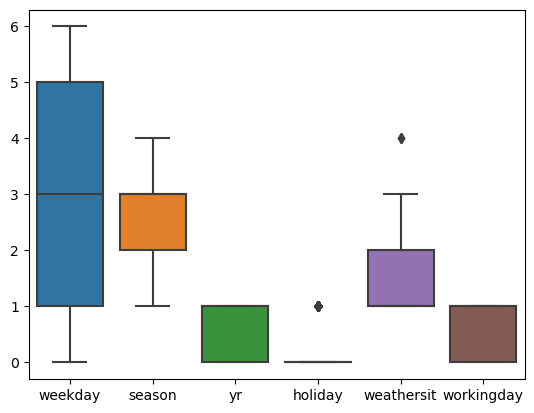

In [8]:
# plot categorical variables
categorical_cols = df1[["weekday", 
            "season", 
            "yr", 
            "holiday",
            "weathersit",
            "workingday"]]

sns.boxplot(data=categorical_cols)

Insights:
- There seems to be a similar distribution across weekdays
- There are 4 seasons as expected with similar distribution across them
- We only have data for 2 years, encoded as 0 and 1. There are more rentals in 2012 than in 2011
- There are many more rentals on non-holidays than holidays
- There are few data points for weathersit = 4, so less people rent bikes when there are harsh weather conditions

<AxesSubplot:>

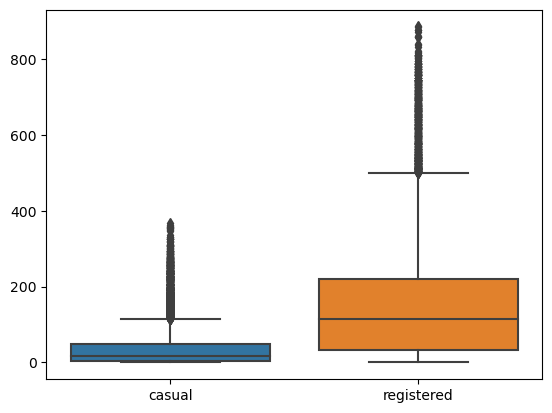

In [9]:
# boxplots of numerical variables
numerical_cols = df1[["temp", 
            "atemp", 
            "hum", 
            "windspeed", 
            "casual", 
            "registered", 
            "mnth", 
            "hr"]]

sns.boxplot(data=df1[["casual", "registered"]])

<AxesSubplot:>

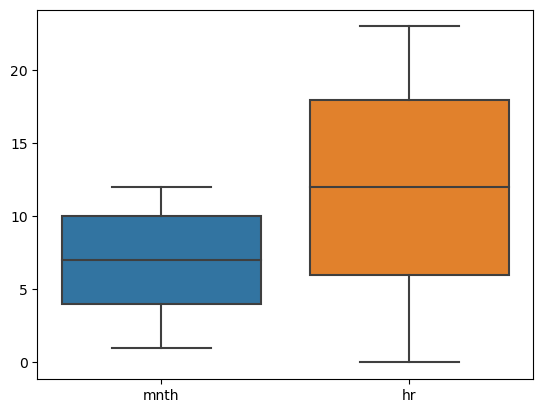

In [10]:
sns.boxplot(data=df1[["mnth", 
            "hr"]])

<AxesSubplot:>

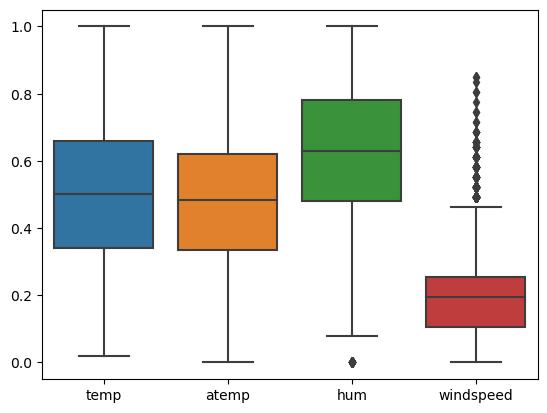

In [11]:
sns.boxplot(data=df1[["temp", 
            "atemp", 
            "hum", 
            "windspeed"]])

Numerical variables key findings:
- There are more registered than casual users but both have quite a few outliers who rent bikes very often
- Month and hour do not have any significant outliers
- Temperature and air temperature have similar distributions and no significant outliers
- Humidity has one outliers, with very low humidity
- Windspeed has quite a few outliers with high windspeed

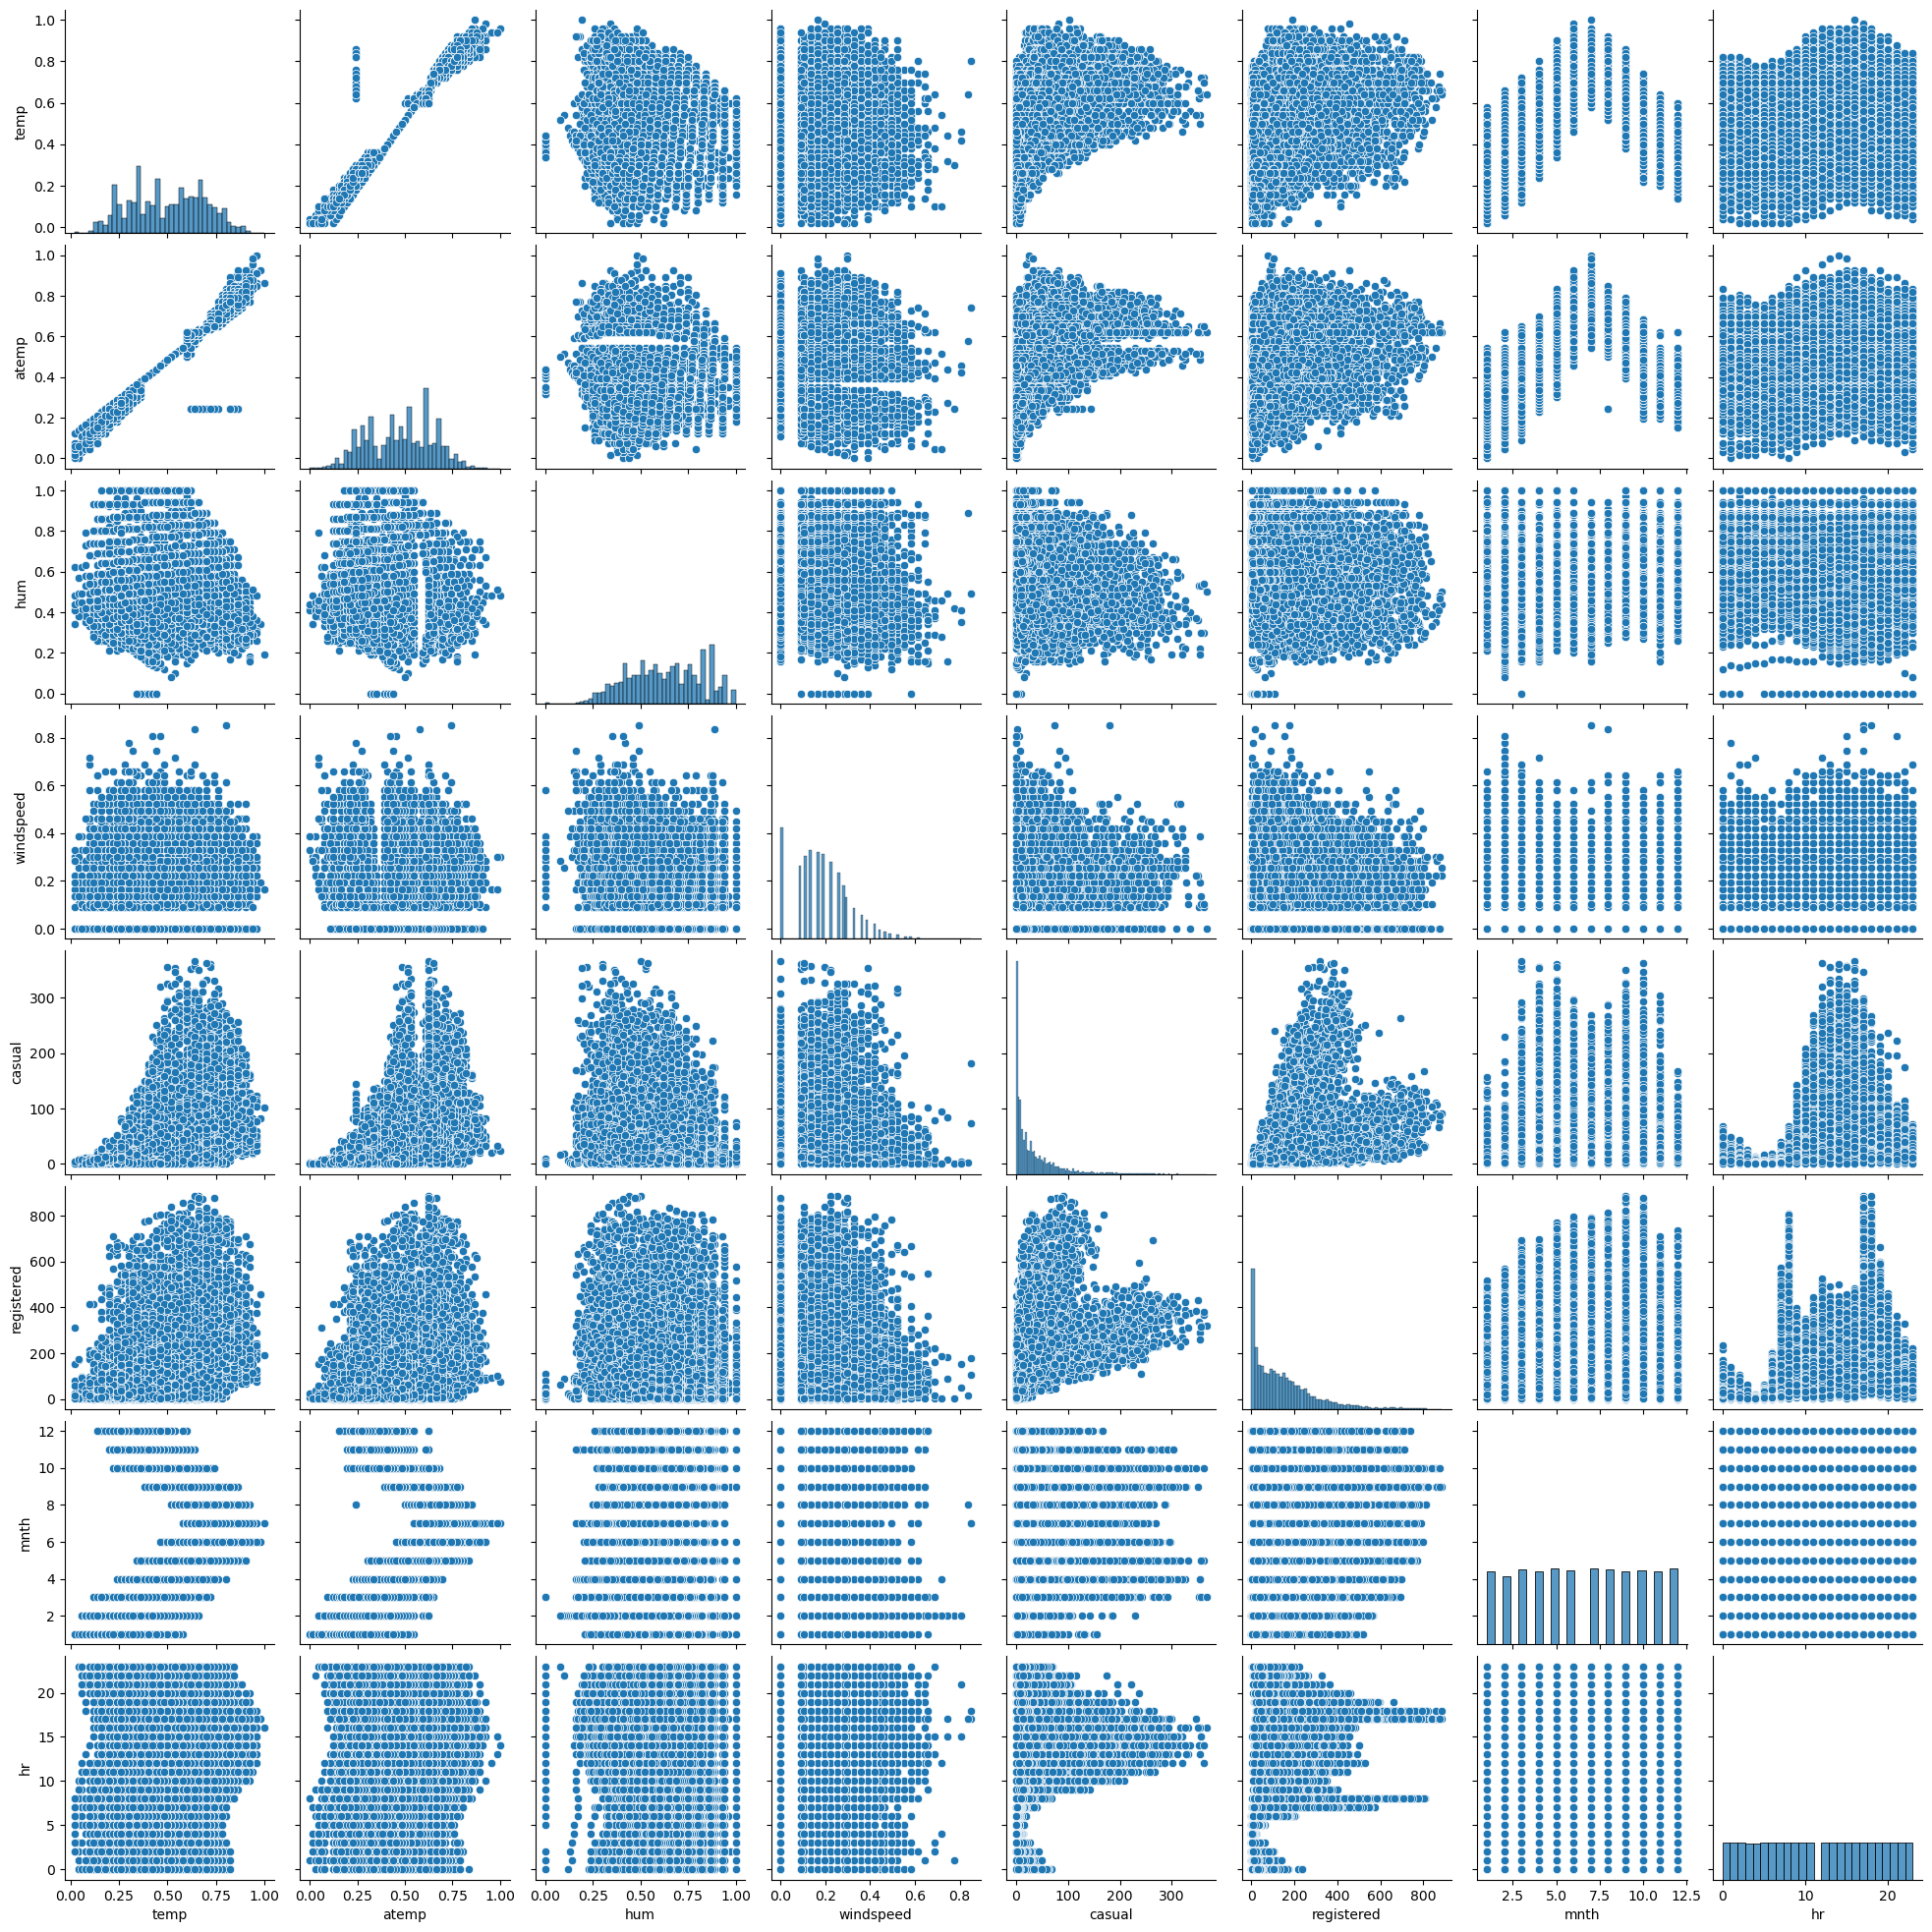

In [12]:
# pair plots of numerical variables
sns.pairplot(numerical_cols)

Insights:
- temp, atemp, humidity, mnth and hr seem rougly normally distributed
- windspeed, casual, and registed have a right skewed distribution
- temp and atemp are highly correlated and have some outliers
- casual and registered users seem somewhat correlated and have similar distributions but registered users have higher peaks earlier in the mornign and later in the afternoon, probably people who bike to and from work every day
- temp is higher in the middle months than in the lower and higher months, which makes sense as these are summer months in DC.
- There seems to be a slight positive correlation between temperature and users, suggesting that there are more users whent he temperatures are higher
- There seems to be a slight negative correlation between number of users and windspeed, suggesting that less bikes are used when there is more wind.

Below we analyze the number of registered and casual users per categorical variable

In [13]:
# define function to compare registered vs casual users for each categorical variable using bar plots

def plot_grouped_data_cat(df1, groupby_col, data_col1, data_col2):
    grouped = df1.groupby(groupby_col).sum()

    # create a bar chart
    fig, ax = plt.subplots()
    n_categories = len(grouped.index)
    width = 0.9 / n_categories  # width of the bars, adjusted for number of categories
    offset = width / 2  # offset for positioning the bars

    for i, col in enumerate([data_col1, data_col2]):
        positions = [j + (i - 0.5) * width for j in range(n_categories)]
        ax.bar(positions, grouped[col], width=width, label=col.capitalize())

    ax.set_xticks(range(n_categories))
    ax.set_xticklabels(grouped.index)
    ax.legend()
    ax.grid(False)
    plt.show()

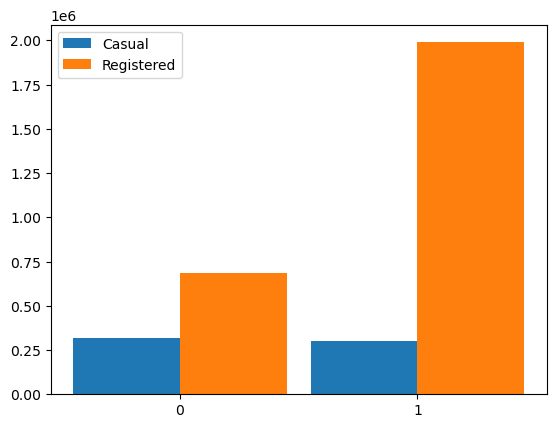

In [14]:
plot_grouped_data_cat(df1, df1["workingday"], "casual", "registered")

From the plot above we see that there are more registered users than casual users both on working days and non working days but that thre are a lot more registered users on working days than on non working days. From this plot it is hard to tell if the trend is the same for casual users so we plot the two types of users on all weekdays below.

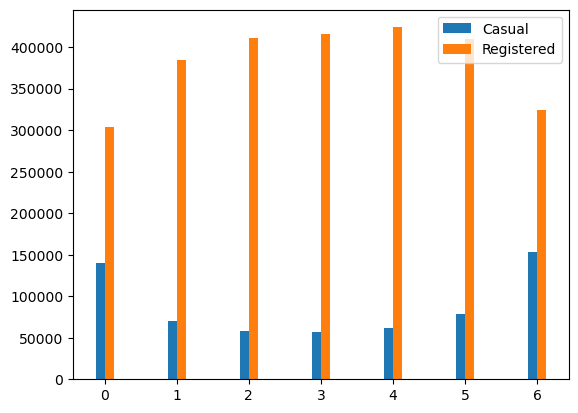

In [15]:
plot_grouped_data_cat(df1, df1["weekday"], "casual", "registered")

In the plot above we see that casual users use more bikes on Sundays (0) and Saturdays (6), so on weekends which makes sense. On the other hand, registered users use more bieks on the weekdays.

Below we analyze the number of registered and casual users per numerical variable

In [16]:
# define function to compare registered vs casual users for each numerical variable using scatterplots

def plot_grouped_data_num(df1, groupby_col, data_col1, data_col2):
    grouped = df1.groupby(groupby_col).sum()

    # create a scatterplot
    fignum, ax = plt.subplots()

    for i, col in enumerate([data_col1, data_col2]):
        ax.scatter(grouped.index, grouped[col], label=col.capitalize(), c=['b', 'r'][i])

    ax.set_xticks(grouped.index[::8]) #set x-axis ticks at intervals of 8
    ax.set_xticklabels(grouped.index[::8])
    ax.legend()
    ax.grid(False)
    plt.show()

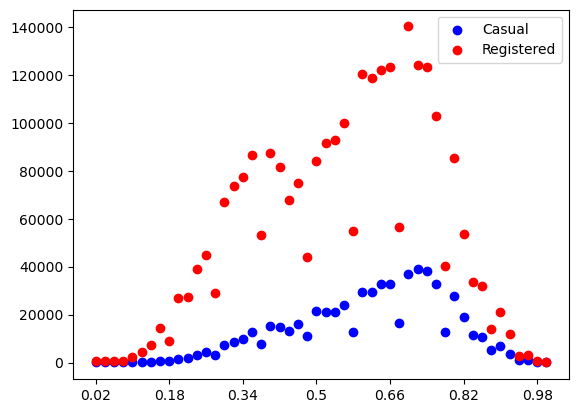

In [17]:
plot_grouped_data_num(df1, df1["temp"], "casual", "registered")

In the plot above we see that casual and registered users per temperature follow a similar distribution, except that there are many more registered than casual users. There are few users at low and high temperatures, and most users are concentrated around mid to high temperatures.

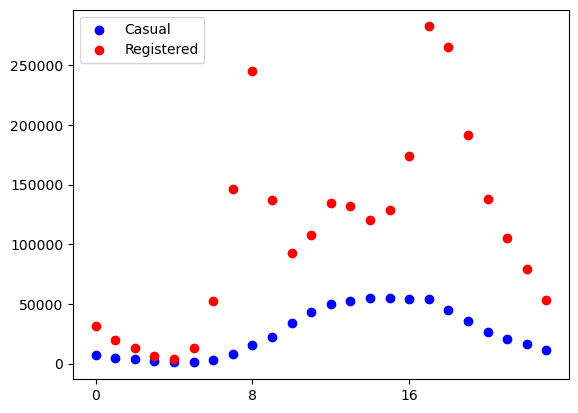

In [18]:
plot_grouped_data_num(df1, df1["hr"], "casual", "registered")

In the plot above we see that the distribution of casual and registered users per hour is different. Casual users rent bikes throughout the day, increasing from the morning until about 3:00pm and then decreasing again, showing a smooth pattern. Registered users on the other hand rent many bikes around 8:00am and again around 5:00pm, suggesting that many of these users rent bikes to go to and from work.

Below we plot bar plots of each categorical variable with the target variable "cnt" (sum of registered and casual users)

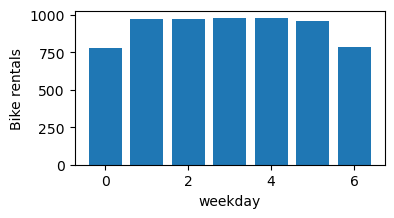

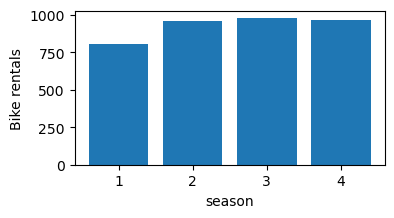

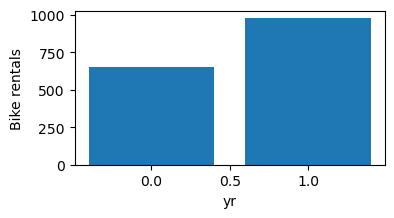

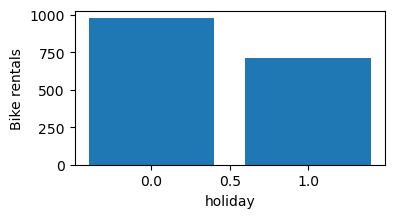

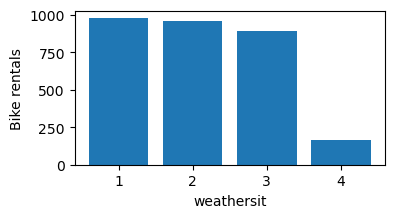

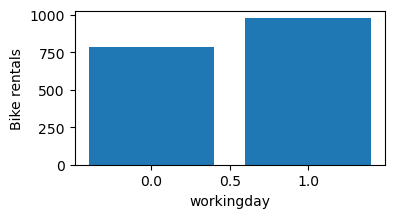

In [19]:
# plot bar plots of each categorical variable against target variable
for col in categorical_cols.columns:
    fig, ax = plt.subplots(figsize=(4, 2))
    plt.bar(categorical_cols[col], df1['cnt'])
    plt.xlabel(col)
    plt.ylabel('Bike rentals')
    plt.show()

Insights:
- Overall, weekends have less bike users in total. We previously saw that casual users use more bikes on the weekends whereas registered users rent more bikes during the week, suggesting that this decrease in bike users over the weekend relative to the working week is driven by fewer registered users.
- Spring has the least bike rentals relative to other seasons
- 2012 has more bike rentals than 2011
- Not many people rent bikes on holidays relative to non holidays
- Very few people rent bikes when the weather is bad

Below we plot scatterplots of each categorical variable with the target variable "cnt" (sum of registered and casual users)

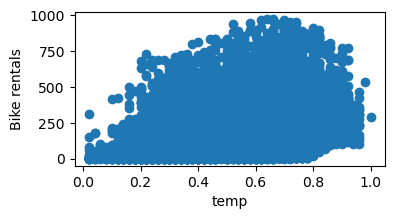

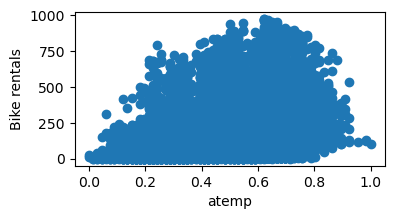

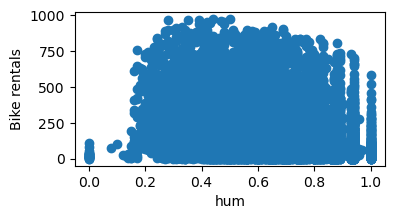

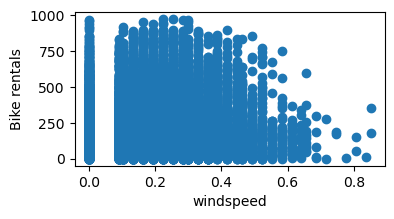

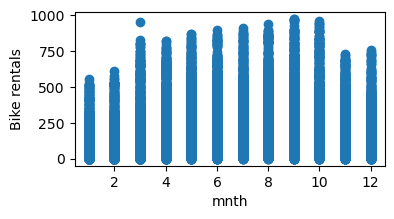

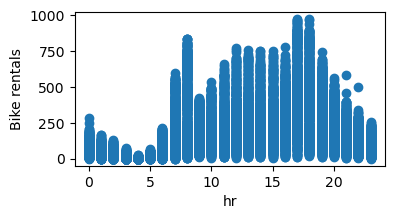

In [20]:
# plot scatterplots of each numerical feature against target variable
for col in numerical_cols.columns:
    if col not in ['casual', 'registered']:
        fig, ax = plt.subplots(figsize=(4, 2))
        plt.scatter(numerical_cols[col], df1['cnt'])
        plt.xlabel(col)
        plt.ylabel('Bike rentals')
        plt.show()

Insights:
- It is difficult to tell if there is a clear relatinoship between temperature, humidity and the target variable so these may not be important factors in predicting it.
- As windspeed increases, the number of rentals decreases, which makes sense as it is difficult to bike in strong winds.
- Bikes are rented throughout the year with january having the least bike rentals and September having the most. There seem to be more rentals in the warmer summer months.
- Bike rentals peak at 8:00am and again at 5:00 and 6:00pm, which is probably driven by renters who bike to and from work, as previously mentioned.

Below we analyze correlations between our features.

<AxesSubplot:>

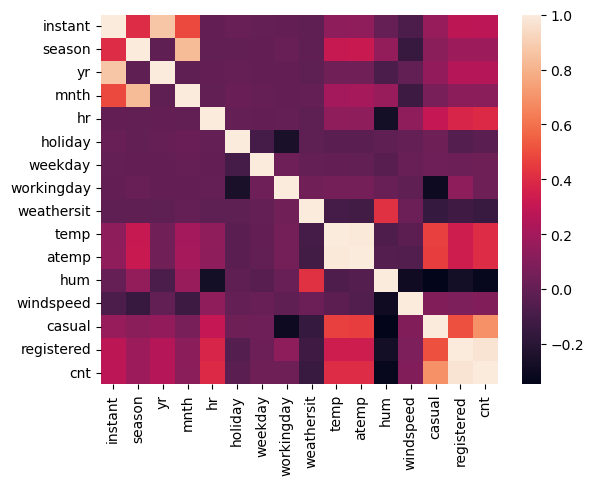

In [21]:
# correlation plot
sns.heatmap(df1.corr())

Insights:
- Season is positively correlated with months
- Workingday is correlated with holiday which makes sense as all holidays are not working days, so one of these variables should be removed to avoid introducing irrelevant noisy features into the model.
- Many features are negatively correlated with humidity: hour, registered, casual, and windspeed so might be useful to remove humidity from the model. However, it has a strong negative correlation with the target variable, suggesting it could be useful to keep in.
- Working day is negatively correlated with casual because casual suers use less bikes on work days 
- Registered and casual have to be removed, as these are a subset of the target.

Features to remove from model based on above: 
- holiday
- registered
- casual

Below we feature engineer new features that we think could be useful to improve model performance

### Feature Engineering

In [22]:
# new features

# month start boolean
df["mnth_start"]=df["dteday"].dt.is_month_start

# month end boolean
df["mnth_end"]=df["dteday"].dt.is_month_end

#quarter of year
df["quarter"]=df["dteday"].dt.quarter

#Previous day date
df["dte_yesterday"] = df["dteday"] - pd.Timedelta(1, unit='D')

#day extraction
df["day"]=df["dteday"].dt.day
test_df["day"]=test_df["dteday"].dt.day

# is weekend boolean
df["is_weekend"] = np.where(df["weekday"] < 5, 0, 1)
test_df["is_weekend"] = np.where(test_df["weekday"] < 5, 0, 1)

# period of day (morning, afternoon, evening, night)
df["day_period"] = np.where(df['hr'] <= 5, '1', 
                            np.where(df['hr'].between(6, 11, inclusive='both'), '2',
                                     np.where(df['hr'].between(12, 17, inclusive='both'), '3',
                                              np.where(df['hr'].between(18, 23, inclusive='both'), '4', '0'))))

test_df["day_period"] = np.where(test_df['hr'] <= 5, '1', 
                            np.where(test_df['hr'].between(6, 11, inclusive='both'), '2',
                                     np.where(test_df['hr'].between(12, 17, inclusive='both'), '3',
                                              np.where(test_df['hr'].between(18, 23, inclusive='both'), '4', '0'))))

# weather factor
df["weather_factor"] = df["windspeed"] * df["weathersit"]
test_df["weather_factor"] = test_df["windspeed"] * test_df["weathersit"]

## Temperature

# minimum daily temperature
df["min_daily_temp"] = df.groupby('dteday')['temp'].transform('min')
test_df["min_daily_temp"] = test_df.groupby('dteday')['temp'].transform('min')

# max daily temperature
df["max_daily_temp"] = df.groupby('dteday')['temp'].transform('max')
test_df["max_daily_temp"] = test_df.groupby('dteday')['temp'].transform('max')

# mean daily temperature
df["mean_daily_temp"] = df.groupby('dteday')['temp'].transform('mean')
test_df["mean_daily_temp"] = test_df.groupby('dteday')['temp'].transform('mean')

# Humidity

# minimum daily temperature
df["min_daily_hum"] = df.groupby('dteday')['hum'].transform('min')
test_df["min_daily_hum"] = test_df.groupby('dteday')['hum'].transform('min')

# max daily temperature
df["max_daily_hum"] = df.groupby('dteday')['hum'].transform('max')
test_df["max_daily_hum"] = test_df.groupby('dteday')['hum'].transform('max')

# mean daily temperature
df["mean_daily_hum"] = df.groupby('dteday')['hum'].transform('mean')
test_df["mean_daily_hum"] = test_df.groupby('dteday')['hum'].transform('mean')


# rush hour on working days AM & PM
df['is_rush_hour'] = ((df['workingday'] == 1) & (df['hr'].isin([8, 17, 18]))).astype(int)
test_df['is_rush_hour'] = ((test_df['workingday'] == 1) & (test_df['hr'].isin([8, 17, 18]))).astype(int)

# Getting features previously created but for the previous day

yesterday_df = df[[
    "dteday", 
   "mean_daily_temp", "mean_daily_hum",
  "min_daily_temp", "min_daily_hum",
 "max_daily_temp", "max_daily_hum",
"weather_factor", "hr"
        ]]
yesterday_df = yesterday_df.rename(columns={'dteday': 'dte_yesterday',
                                           'mean_daily_temp': 'ytd_mean_daily_temp',
                                          'mean_daily_hum': 'ytd_mean_daily_hum',
                                         'min_daily_temp': 'ytd_min_daily_temp',
                                       'max_daily_temp': 'ytd_max_daily_temp',
                                      'max_daily_hum': 'ytd_max_daily_hum',
                                     'weather_factor': 'ytd_weather_factor',
                                                                      })

# join df with new features for previous day
#df = pd.merge(df, yesterday_df, on=['dte_yesterday', 'hr'], how='inner')
#df.dropna(inplace=True)

In [23]:
# convert time features into their cosine, as they are cyclical
df['cos_hour'] = df['hr'].map(
    lambda h: np.cos(2*np.pi*h/24)
)
df['cos_month'] = df['mnth'].map(
    lambda h: np.cos(2*np.pi*h/12)
)
df['cos_weekday'] = df['weekday'].map(
    lambda h: np.cos(2*np.pi*h/7)
)
df['cos_day'] = df['day'].map(
    lambda h: np.cos(2*np.pi*h/31)
)

# for validation set
test_df['cos_hour'] = test_df['hr'].map(
    lambda h: np.cos(2*np.pi*h/24)
)
test_df['cos_month'] = test_df['mnth'].map(
    lambda h: np.cos(2*np.pi*h/12)
)
test_df['cos_weekday'] = test_df['weekday'].map(
    lambda h: np.cos(2*np.pi*h/7)
)
test_df['cos_day'] = test_df['day'].map(
    lambda h: np.cos(2*np.pi*h/31)
)

In [24]:
# define numerical, categorical, and date features. 
# final features after checking RFECV and Feature Importance plot

num_feat = ["temp", 
            "atemp", 
            "hum", 
            "windspeed", 
            "cos_month", 
            "cos_hour",
            "cos_weekday",
            "cos_day",
            "weather_factor",
            "min_daily_temp",
            "max_daily_temp",
            "mean_daily_temp",
            "min_daily_hum",
            "max_daily_hum",
            "mean_daily_hum"
           ]

cat_feat = ["season", 
            "yr",  
            "is_weekend",
            "day_period",
            "weathersit",
            "is_rush_hour"
           ]

date_feat = ["dteday"]


target_feat = ["cnt"]

In [25]:
# sort values by date before doing final split into train and test
df = df.sort_values(["dteday", "hr"])
test_df = test_df.sort_values(["dteday","hr"])

In [26]:
# define X and Y df's before doing final split for test
X_df = df[[*num_feat, *cat_feat]]
y_df = df[[*target_feat]]

X_test = test_df[[*num_feat, *cat_feat]]
y_test = test_df[[*target_feat]]

## PART II: Prediction Model

### Splitting Datasets

In [27]:
# manual time series split for testing set (80-10-10)
# first 10% of the time series already contained in "validation_df"

training_proportion =  0.90

maximum_training_row = int(len(df) * training_proportion)

# create the first dataset with the first 80% of the rows
X_train = X_df.iloc[:maximum_training_row,:]
y_train = y_df.iloc[:maximum_training_row,:].squeeze()

# create the second dataset with the last 20% of the rows
X_val = X_df.iloc[maximum_training_row:,:]
y_val = y_df.iloc[maximum_training_row:,:].squeeze()

### Data Transformations

In [28]:
#Scaling numerical features, and one hot encoding categorical features 

# Create the transformers for each data type
num_transformer = Pipeline(steps=[('num_scaler', StandardScaler())])
#date_transformer = Pipeline(steps=[('date_noop', FunctionTransformer(lambda x: x))])
cat_transformer = Pipeline(steps=[('encoder', OneHotEncoder())])

# Define the preprocessor, specifying which transformers to apply to each data type
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_feat),
    ('cat', cat_transformer, cat_feat)])

# Fit and transform the data using the preprocessor
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
X_val_processed = preprocessor.transform(X_val)

# Get the names of the columns after transformation
num_col_names = num_feat
cat_col_names = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(cat_feat)

# Combine the transformed data and column names into a pandas dataframe
X_train_final = pd.DataFrame(X_train_processed, columns=num_col_names + list(cat_col_names))
X_test_final = pd.DataFrame(X_test_processed, columns=num_col_names + list(cat_col_names))
X_val_final = pd.DataFrame(X_val_processed, columns=num_col_names + list(cat_col_names))

## Models

### 1. Logistic Regression

In [29]:
# create a Linear Regression model
linreg_model = LinearRegression()

# define the hyperparameter grid
param_grid_linreg = {
    'fit_intercept': [True, False]}

# create a GridSearchCV object
grid_linreg = GridSearchCV(linreg_model, param_grid=param_grid_linreg, scoring='r2', cv=5)

# fit the GridSearchCV object to the training data
grid_linreg.fit(X_train_final, y_train)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]}, scoring='r2')

In [30]:
# predict the labels of the data values on the basis of the trained model
# scoring for train and validation sets

# Predictions
y_pred_train_linreg = grid_linreg.predict(X_train_final)

y_pred_val_linreg = grid_linreg.predict(X_val_final)

# Create a list of dictionaries
metrics_linreg = [
     {'set': 'Train', 'metric': 'R2 score', 'value': r2_score(y_train, y_pred_train_linreg)},    
     {'set': 'Train', 'metric': 'MSE', 'value': mean_squared_error(y_train, y_pred_train_linreg)},    
     {'set': 'Train', 'metric': 'MAE', 'value': mean_absolute_error(y_train, y_pred_train_linreg)},    
     {'set': 'Validation', 'metric': 'R2 score', 'value': r2_score(y_val, y_pred_val_linreg)},    
     {'set': 'Validation', 'metric': 'MSE', 'value': mean_squared_error(y_val, y_pred_val_linreg)},    
     {'set': 'Validation', 'metric': 'MAE', 'value': mean_absolute_error(y_val, y_pred_val_linreg)}]

# Create the DataFrame
metrics_linreg = pd.DataFrame(metrics_linreg)


# Pivot the DataFrame
metrics_linreg.pivot(index='metric', columns='set', values='value')

set             Train    Validation
metric                             
MAE         70.719632    116.653791
MSE       8451.512156  22725.798014
R2 score     0.701799      0.609702

In [31]:
# check the best parameters found by Linear Regression Grid Search
print(grid_linreg.best_params_)

{'fit_intercept': False}


#### Model insights
Lienar regression is a simple and interpretable model, but it may not capture complex nonlinear relationships in our data given the low r2 scores achieved.

### 2. K Nearest Neighbor

In [32]:
# create a KNN Regressor
knn_model = KNeighborsRegressor()

# define the hyperparameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# create a GridSearchCV object
grid_knn = GridSearchCV(knn_model, param_grid=param_grid_knn, scoring='r2', cv=5)

# fit the GridSearchCV object to the training data
grid_knn.fit(X_train_final, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [3, 5, 7], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='r2')

In [33]:
# predict the labels of the data values on the basis of the trained model
# scoring for train and validation sets

# Predictions
y_pred_train_knn = grid_knn.predict(X_train_final)

y_pred_val_knn = grid_knn.predict(X_val_final)

# Create a list of dictionaries
metrics_knn = [
     {'set': 'Train', 'metric': 'R2 score', 'value': r2_score(y_train, y_pred_train_knn)},    
     {'set': 'Train', 'metric': 'MSE', 'value': mean_squared_error(y_train, y_pred_train_knn)},    
     {'set': 'Train', 'metric': 'MAE', 'value': mean_absolute_error(y_train, y_pred_train_knn)},    
     {'set': 'Validation', 'metric': 'R2 score', 'value': r2_score(y_val, y_pred_val_knn)},    
     {'set': 'Validation', 'metric': 'MSE', 'value': mean_squared_error(y_val, y_pred_val_knn)},    
     {'set': 'Validation', 'metric': 'MAE', 'value': mean_absolute_error(y_val, y_pred_val_knn)}]

# Create the DataFrame
metrics_knn = pd.DataFrame(metrics_knn)

# Pivot the DataFrame
metrics_knn.pivot(index='metric', columns='set', values='value')

set       Train    Validation
metric                       
MAE         0.0     92.776480
MSE         0.0  17413.826887
R2 score    1.0      0.700931

In [34]:
# check the best parameters found by KNN Grid Search
print(grid_knn.best_params_)

{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}


#### Model insights
KNN was chosein since we identified some nonlinear relationships in our data and since it can handle both categorical and continuous predictors.
One of the the cons we found was an even lower r2 score before reducing the features of our model.

### 3. Decision Tree

In [35]:
# create a Decision Tree Regressor
dt_model = DecisionTreeRegressor()

# define the hyperparameter grid
param_grid_dt = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# create a GridSearchCV object
grid_dt = GridSearchCV(dt_model, param_grid=param_grid_dt, scoring='r2', cv=5)

# fit the GridSearchCV object to the training data
grid_dt.fit(X_train_final, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [3, 5, 7],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 8]},
             scoring='r2')

In [36]:
# predict the labels of the data values on the basis of the trained model
# scoring for train and validation sets

# Predictions
y_pred_train_dt = grid_dt.predict(X_train_final)

y_pred_val_dt = grid_dt.predict(X_val_final)

# Create a list of dictionaries
metrics_dt = [
     {'set': 'Train', 'metric': 'R2 score', 'value': r2_score(y_train, y_pred_train_dt)},    
     {'set': 'Train', 'metric': 'MSE', 'value': mean_squared_error(y_train, y_pred_train_dt)},    
     {'set': 'Train', 'metric': 'MAE', 'value': mean_absolute_error(y_train, y_pred_train_dt)},    
     {'set': 'Validation', 'metric': 'R2 score', 'value': r2_score(y_val, y_pred_val_dt)},    
     {'set': 'Validation', 'metric': 'MSE', 'value': mean_squared_error(y_val, y_pred_val_dt)},    
     {'set': 'Validation', 'metric': 'MAE', 'value': mean_absolute_error(y_val, y_pred_val_dt)}]

# Create the DataFrame
metrics_dt = pd.DataFrame(metrics_dt)

# Pivot the DataFrame
metrics_dt.pivot(index='metric', columns='set', values='value')

set             Train    Validation
metric                             
MAE         53.197418     90.768061
MSE       5858.352117  16715.104558
R2 score     0.793296      0.712931

In [37]:
# check the best parameters found by Decision Tree Grid Search
print(grid_dt.best_params_)

{'max_depth': 7, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 5}


#### Model insights
Decision Tree was found to be overfitting on the training set before reducing the model's complexity. Next step was to find models that helped us reduce overfitting while maximizing the Test score. 

### 4. Random Forest

In [38]:
# create a Random Forest Regressor
rf_model = RandomForestRegressor()


# define the hyperparameter grid
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': [None]
}

# create a GridSearchCV object
grid_rf = GridSearchCV(rf_model, param_grid=param_grid_rf, scoring='r2', cv=5)

grid_rf.fit(X_train_final, y_train)

# create an RFECV object
rfecv = RFECV(estimator=grid_rf.best_estimator_, step=1, cv=5, scoring='r2', n_jobs=-1)

# fit the GridSearchCV object to the training data
rfecv.fit(X_train_final, y_train)

RFECV(cv=5,
      estimator=RandomForestRegressor(max_depth=7, max_features=None,
                                      min_samples_split=5),
      n_jobs=-1, scoring='r2')

In [39]:
# predict the labels of the data values on the basis of the trained model
# scoring for train and validation sets

# Predictions
y_pred_train_rf = grid_rf.predict(X_train_final)

y_pred_val_rf = grid_rf.predict(X_val_final)

# Create a list of dictionaries
metrics_rf = [
     {'set': 'Train', 'metric': 'R2 score', 'value': r2_score(y_train, y_pred_train_rf)},    
     {'set': 'Train', 'metric': 'MSE', 'value': mean_squared_error(y_train, y_pred_train_rf)},    
     {'set': 'Train', 'metric': 'MAE', 'value': mean_absolute_error(y_train, y_pred_train_rf)},    
     {'set': 'Validation', 'metric': 'R2 score', 'value': r2_score(y_val, y_pred_val_rf)},    
     {'set': 'Validation', 'metric': 'MSE', 'value': mean_squared_error(y_val, y_pred_val_rf)},    
     {'set': 'Validation', 'metric': 'MAE', 'value': mean_absolute_error(y_val, y_pred_val_rf)}]

# Create the DataFrame
metrics_rf = pd.DataFrame(metrics_rf)

# Pivot the DataFrame
metrics_rf.pivot(index='metric', columns='set', values='value')

set             Train    Validation
metric                             
MAE         48.974646     81.934871
MSE       5035.168670  13862.455060
R2 score     0.822341      0.761923

In [40]:
# check the best parameters found by Random Forest Grid Search
print(grid_rf.best_params_)

{'max_depth': 7, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [41]:
# check the features that rfecv chose and then corroborate with Feature Importance plot
print("Selected features: ", X_train_final.columns[rfecv.support_])

Selected features:  Index(['temp', 'atemp', 'hum', 'windspeed', 'cos_month', 'cos_hour',
       'cos_weekday', 'cos_day', 'weather_factor', 'min_daily_temp',
       'max_daily_temp', 'mean_daily_temp', 'min_daily_hum', 'max_daily_hum',
       'mean_daily_hum', 'season_1', 'season_2', 'season_3', 'season_4',
       'yr_0', 'yr_1', 'is_weekend_0', 'is_weekend_1', 'day_period_1',
       'day_period_2', 'day_period_3', 'day_period_4', 'weathersit_1',
       'weathersit_2', 'weathersit_3', 'weathersit_4', 'is_rush_hour_0',
       'is_rush_hour_1'],
      dtype='object')


#### Model insights
Given the overfitting present in the Decision Tree model before feature reduction, Random Forest was chosen since one of it's strengths is to reduce overfitting and improve generalization, recursive feature elimination CV was integrated to this model to help reduce overfitting even more and start to identify relevant variables. 

We found this model to be computationally expensive, since it took the longest to fit and the results we're not extraordinary. 

### 5. Elastic Net

In [42]:
# create an ElasticNet
enet_model = ElasticNet()

# define the hyperparameter grid
param_grid_enet = {'alpha': [0.01, 0.1, 1],
              'l1_ratio': [0.25, 0.5, 0.75],
              'max_iter': [1000, 5000, 10000]}

# create a GridSearchCV object
grid_enet = GridSearchCV(enet_model, param_grid=param_grid_enet, scoring='r2', cv=5)

# fit the GridSearchCV object to the training data
grid_enet.fit(X_train_final, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.01, 0.1, 1], 'l1_ratio': [0.25, 0.5, 0.75],
                         'max_iter': [1000, 5000, 10000]},
             scoring='r2')

In [43]:
# predict the labels of the data values on the basis of the trained model
# scoring for train, test and validation sets

# Predictions
y_pred_train_enet = grid_enet.predict(X_train_final)

y_pred_val_enet = grid_enet.predict(X_val_final)

# Create a list of dictionaries
metrics_enet = [
     {'set': 'Train', 'metric': 'R2 score', 'value': r2_score(y_train, y_pred_train_enet)},    
     {'set': 'Train', 'metric': 'MSE', 'value': mean_squared_error(y_train, y_pred_train_enet)},    
     {'set': 'Train', 'metric': 'MAE', 'value': mean_absolute_error(y_train, y_pred_train_enet)},    
     {'set': 'Validation', 'metric': 'R2 score', 'value': r2_score(y_val, y_pred_val_enet)},    
     {'set': 'Validation', 'metric': 'MSE', 'value': mean_squared_error(y_val, y_pred_val_enet)},    
     {'set': 'Validation', 'metric': 'MAE', 'value': mean_absolute_error(y_val, y_pred_val_enet)}]

# Create the DataFrame
metrics_enet = pd.DataFrame(metrics_enet)

# Pivot the DataFrame
metrics_enet.pivot(index='metric', columns='set', values='value')

set             Train    Validation
metric                             
MAE         72.457447    123.697717
MSE       8920.572920  26846.708991
R2 score     0.685249      0.538928

In [44]:
# check the best parameters found by Elastic Net Grid Search
print(grid_enet.best_params_)

{'alpha': 0.1, 'l1_ratio': 0.5, 'max_iter': 1000}


#### Model insights

Elastic net was chosen to compare it's results to Random Forest's, given that both help reducing overfitting, it was important to compare how a regularized linear regression model performed vs a Desicion Tree model. 

### 6. Gradient Boosting

In [45]:
# create a Gradient Boosting Regressor
gb_model = GradientBoostingRegressor()

# define the hyperparameter grid
param_grid_gb = {
    'n_estimators': [100, 150],
    'max_depth': [5, 7],
    'min_samples_split': [5, 7],
    'min_samples_leaf': [1, 2],
    'max_features': [None]
}

# create a GridSearchCV object
grid_gb  = GridSearchCV(gb_model, param_grid=param_grid_gb, scoring='r2', cv=5)

grid_gb.fit(X_train, y_train)

# create an RFECV object
rfecv_gb = RFECV(estimator=grid_gb.best_estimator_, step=1, cv=5, scoring='r2', n_jobs=-1)

# fit the GridSearchCV object to the training data
rfecv_gb.fit(X_train, y_train)

RFECV(cv=5,
      estimator=GradientBoostingRegressor(max_depth=5, min_samples_leaf=2,
                                          min_samples_split=5,
                                          n_estimators=150),
      n_jobs=-1, scoring='r2')

In [46]:
# predict the labels of the data values on the basis of the trained model
# scoring for train and validation sets

# Predictions
y_pred_train_gb = rfecv_gb.predict(X_train)

y_pred_test_gb = rfecv_gb.predict(X_test)

y_pred_val_gb = rfecv_gb.predict(X_val)

# Scoring metrics
train_r2_gb = r2_score(y_train, y_pred_train_gb)
train_mse_gb = mean_squared_error(y_train, y_pred_train_gb)
train_mae_gb = mean_absolute_error(y_train, y_pred_train_gb)

test_r2_gb = r2_score(y_test, y_pred_test_gb)
test_mse_gb = mean_squared_error(y_test, y_pred_test_gb)
test_mae_gb = mean_absolute_error(y_test, y_pred_test_gb)

val_r2_gb = r2_score(y_val, y_pred_val_gb)
val_mse_gb = mean_squared_error(y_val, y_pred_val_gb)
val_mae_gb = mean_absolute_error(y_val, y_pred_val_gb)

# Create a list of dictionaries
metrics_gb = [
     {'set': 'Train', 'metric': 'R2 score', 'value': train_r2_gb},    
     {'set': 'Train', 'metric': 'MSE', 'value': train_mse_gb},    
     {'set': 'Train', 'metric': 'MAE', 'value': train_mae_gb},    
     {'set': 'Test', 'metric': 'R2 score', 'value': test_r2_gb},    
     {'set': 'Test', 'metric': 'MSE', 'value': test_mse_gb},    
     {'set': 'Test', 'metric': 'MAE', 'value': test_mae_gb},
     {'set': 'Validation', 'metric': 'R2 score', 'value': val_r2_gb},    
     {'set': 'Validation', 'metric': 'MSE', 'value': val_mse_gb},    
     {'set': 'Validation', 'metric': 'MAE', 'value': val_mae_gb}]

# Create the DataFrame
metrics_gb = pd.DataFrame(metrics_gb)

# Pivot the DataFrame
metrics_gb.pivot(index='metric', columns='set', values='value')

set              Test        Train   Validation
metric                                         
MAE         55.754251    25.608000    57.581701
MSE       6479.436265  1438.420849  6948.865617
R2 score     0.816710     0.949247     0.880658

In [47]:
# check the best parameters found by Gradient Boosting Grid Search
print(grid_gb.best_params_)

{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}


In [48]:
# check the best features found by Gradient Boosting Grid Search
# check feature importance plot too and remove irrelevant features
print("Selected features: ", X_train.columns[rfecv_gb.support_])

Selected features:  Index(['temp', 'atemp', 'hum', 'cos_month', 'cos_hour', 'cos_weekday',
       'weather_factor', 'min_daily_temp', 'max_daily_temp', 'mean_daily_temp',
       'mean_daily_hum', 'season', 'yr', 'is_weekend', 'day_period',
       'weathersit', 'is_rush_hour'],
      dtype='object')


#### Model Insights

Given the low results achieved in the rest of the models, Gradient Boosting was chosen because of it's method of combining weak models to achieve a strong predictor. The model seems generalizes well also to new and unseen data, as seen in test and validation scores. RFECV was applied to the final model, which helped us to identify and remove the weakest features to optimize our model. 

### Final Model

In [49]:
# run final model with best hyperparameters found by grid search and best features found by RFECV
# since its a tree model, we don't need one hot encoded features, so we use the original Test and Train data sets

X_train_selected = X_train[['temp', 'atemp', 'hum', 'cos_month', 'cos_hour', 'cos_weekday',
       'weather_factor', 'min_daily_temp', 'max_daily_temp', 'mean_daily_temp',
       'min_daily_hum', 'mean_daily_hum', 'season', 'yr', 'is_weekend',
       'day_period', 'weathersit', 'is_rush_hour']]
X_test_selected = X_test[['temp', 'atemp', 'hum', 'cos_month', 'cos_hour', 'cos_weekday',
       'weather_factor', 'min_daily_temp', 'max_daily_temp', 'mean_daily_temp',
       'min_daily_hum', 'mean_daily_hum', 'season', 'yr', 'is_weekend',
       'day_period', 'weathersit', 'is_rush_hour']]

X_val_selected = X_val[['temp', 'atemp', 'hum', 'cos_month', 'cos_hour', 'cos_weekday',
       'weather_factor', 'min_daily_temp', 'max_daily_temp', 'mean_daily_temp',
       'min_daily_hum', 'mean_daily_hum', 'season', 'yr', 'is_weekend',
       'day_period', 'weathersit', 'is_rush_hour']]

gb_model = GradientBoostingRegressor(max_depth = 5, 
                                        max_features = None, 
                                        min_samples_leaf = 1, 
                                        min_samples_split = 7, 
                                        n_estimators = 150)
gb_model.fit(X_train_selected, y_train)

GradientBoostingRegressor(max_depth=5, min_samples_split=7, n_estimators=150)

In [50]:
# predict the labels of the data values on the basis of the trained model
# scoring for train, test and validation sets

# Predictions
y_pred_train = gb_model.predict(X_train_selected)

y_pred_test = gb_model.predict(X_test_selected)

y_pred_val = gb_model.predict(X_val_selected)


# Scoring metrics
train_r2 = r2_score(y_train, y_pred_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_mae = mean_absolute_error(y_train, y_pred_train)

test_r2 = r2_score(y_test, y_pred_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

val_r2 = r2_score(y_val, y_pred_val)
val_mse = mean_squared_error(y_val, y_pred_val)
val_mae = mean_absolute_error(y_val, y_pred_val)


# Create a list of dictionaries
metrics = [
     {'set': 'Train', 'metric': 'R2 score', 'value': train_r2},    
     {'set': 'Train', 'metric': 'MSE', 'value': train_mse},    
     {'set': 'Train', 'metric': 'MAE', 'value': train_mae},    
     {'set': 'Test', 'metric': 'R2 score', 'value': test_r2},    
     {'set': 'Test', 'metric': 'MSE', 'value': test_mse},    
     {'set': 'Test', 'metric': 'MAE', 'value': test_mae},
     {'set': 'Validation', 'metric': 'R2 score', 'value': val_r2},    
     {'set': 'Validation', 'metric': 'MSE', 'value': val_mse},    
     {'set': 'Validation', 'metric': 'MAE', 'value': val_mae}]
    
# Create the DataFrame
metrics = pd.DataFrame(metrics)

# Pivot the DataFrame
metrics = metrics.pivot(index='metric', columns='set', values='value')

# Reorder the columns
sets = ['Train', 'Test', 'Validation']
metrics = metrics.reindex(columns=sets)
metrics

set             Train         Test   Validation
metric                                         
MAE         25.293324    55.204253    57.389242
MSE       1395.056661  6377.671126  6966.285791
R2 score     0.950777     0.819589     0.880359

In [51]:
# cross validation on training set
results = cross_validate(gb_model, X_train_final, y_train, cv=5, 
                         scoring=["r2","neg_mean_squared_error", "neg_mean_absolute_error"], 
                         return_train_score=True)

results

{'fit_time': array([5.36531234, 5.68301225, 5.60824919, 5.40716863, 5.55379462]),
 'score_time': array([0.01562452, 0.01566505, 0.        , 0.02348971, 0.        ]),
 'test_r2': array([0.55531769, 0.8774765 , 0.6949507 , 0.84329509, 0.85395185]),
 'train_r2': array([0.95581951, 0.95864304, 0.95929819, 0.95743396, 0.94991834]),
 'test_neg_mean_squared_error': array([-3496.21237537, -2724.49279543, -5732.85383063, -4481.00466116,
        -6913.2125511 ]),
 'train_neg_mean_squared_error': array([-1372.40718407, -1232.83532606, -1246.54617071, -1203.67733815,
        -1045.49010053]),
 'test_neg_mean_absolute_error': array([-41.90163487, -35.90392271, -54.14070983, -44.25523557,
        -60.95258559]),
 'train_neg_mean_absolute_error': array([-25.13263867, -23.80934618, -23.69124674, -23.24498597,
        -22.21062386])}

#### Final Model Feature Importance

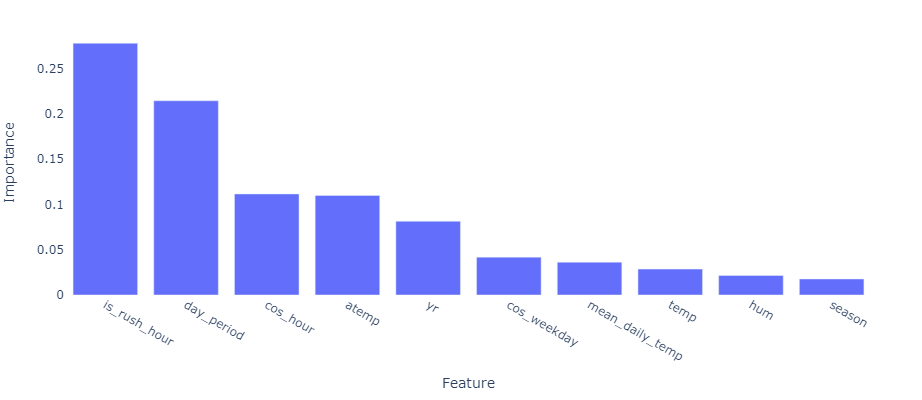

In [52]:
# to visualize feature importance and help in reducing model complexity. 
# top final 10 features visualized by importance

feature_importance = gb_model.feature_importances_
sorted_idx = feature_importance.argsort()
top_k=10
feature_importance_topk = feature_importance[sorted_idx][-top_k:]
feature_names_topk = X_train_selected.columns[sorted_idx][-top_k:]

importances_df = pd.DataFrame({'Feature': feature_names_topk, 'Importance': feature_importance_topk})
importances_df = importances_df.sort_values("Importance", ascending=False)

fig = go.Figure(go.Bar(x=importances_df["Feature"], y=importances_df["Importance"]))

fig.update_layout(
xaxis_title="Feature",
yaxis_title='Importance',
width=400,
height=200,
margin=dict(l=50, r=50, t=30, b=20),
plot_bgcolor='rgba(0,0,0,0)')
fig.update_layout(xaxis=dict(showgrid=False), yaxis=dict(showgrid=False, range=[0, None]), height=400)

#### Final Model Tree Plot

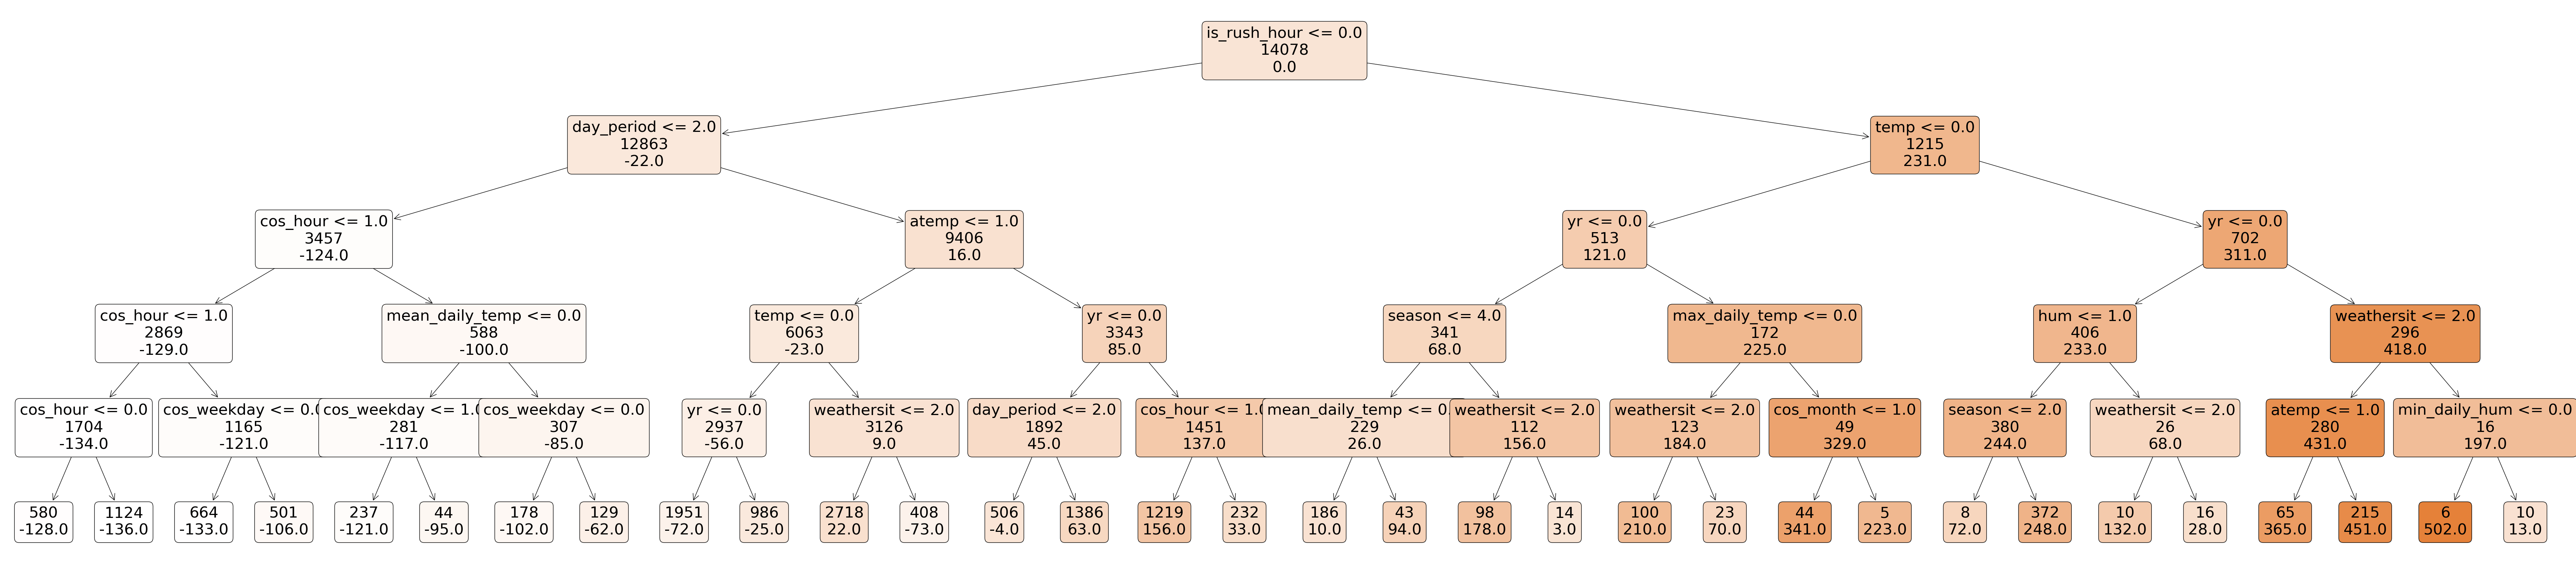

In [53]:
# to visualize our final decision tree

plt.figure(figsize=(90,20))
plot_tree(gb_model.estimators_[2][0], filled=True, 
          rounded=True, fontsize=30, feature_names=gb_model.feature_names_in_, 
          impurity=False, proportion=False, precision=0, node_ids=False, label=None, 
          class_names=None, max_depth=None, ax=None)
plt.show()